In [67]:
# import csv
# import vtk
import pandas as pd
# import matplotlib as mp
# import plotly as px
import matplotlib.pyplot as plt
# import matplotlib.cm
import numpy as np
import cloudvolume
from caveclient import CAVEclient
# import ast
import seaborn as sns
# import networkx as nx
import scikit_posthocs as sp
# from meshparty import trimesh_io, trimesh_vtk, mesh_filters
from scipy import stats
client = CAVEclient('minnie65_phase3_v1')
# print (pd.__version__)
from datetime import datetime, timezone
from ast import literal_eval
# from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [68]:
settime = datetime(2022, 9, 20, 4, 0, 0, 0, tzinfo=timezone.utc)
df_ids_pred_met = pd.read_csv("EM_MC_Predicted_MET_Labels_11_18_22_v1_gr55prob.csv")
print (df_ids_pred_met.head(20))

pre_id_mc = df_ids_pred_met["id"]


    Unnamed: 0                  id predicted_MET-type Label  probability Area
0            0  864691135013417622                Sst-MET-4        1.000   V1
1            8  864691135467660940                Sst-MET-4        1.000   V1
2           11  864691135699487522                Sst-MET-8        1.000   V1
3           14  864691135925834510                Sst-MET-8        1.000   V1
4           19  864691136118647832                Sst-MET-4        1.000   V1
5            9  864691135544588584                Sst-MET-8        0.998   V1
6           10  864691135577202181                Sst-MET-4        0.998   V1
7            6  864691135374222153                Sst-MET-6        0.996   V1
8           18  864691136116457636                Sst-MET-6        0.996   V1
9            1  864691135058985115                Sst-MET-6        0.994   V1
10          12  864691135754152141                Sst-MET-5        0.990   V1
11          16  864691135988665856                Sst-MET-6     

In [69]:
df2 = client.materialize.synapse_query(pre_ids= pre_id_mc, timestamp = settime)
print (df2.head())

          id valid  pre_pt_supervoxel_id      pre_pt_root_id  \
3  176798180     t     90302341240276189  864691135058985115   
4  212519870     t     93667052576919349  864691135013417622   
5  265888405     t     97898730174742508  864691135341516741   
7  251465179     t     96555400500931811  864691135013417622   
9  320698668     t    102401573552128667  864691135341516741   

   post_pt_supervoxel_id     post_pt_root_id  size          pre_pt_position  \
3      90302341240286621  864691135337958630   612  [185518, 204180, 22681]   
4      93667052576920238  864691135941108852  2476  [210306, 107362, 19496]   
5      97828361430566276  864691135584451570  8260  [240696, 178738, 27009]   
7      96555469220403416  864691135544554024  2616  [231298, 131742, 16403]   
9     102401573552128687  864691136209044412  5668  [273514, 172816, 24266]   

          post_pt_position          ctr_pt_position  
3  [185478, 204194, 22689]  [185544, 204164, 22684]  
4  [210398, 107482, 19498]  [210

In [70]:
md3 = client.materialize.query_table('allen_subclass_type_svm_v0',timestamp = settime)
soma_counts = md3['pt_root_id'].value_counts().rename_axis('pt_root_id').reset_index(name ='no_of_somas')
dfm = pd.merge(df2, md3, left_on = 'post_pt_root_id', right_on ='pt_root_id', how = 'right')
singlesomas = soma_counts.loc[soma_counts['no_of_somas'] == 1]
single_soma_merge = pd.merge(md3, singlesomas, left_on = 'pt_root_id', right_on = 'pt_root_id', how = 'inner')
dfm_somas = pd.merge(df2, single_soma_merge, left_on = 'post_pt_root_id', right_on = 'pt_root_id', how = 'inner')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('1P','23P')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('BC','INH')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('MC','INH')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('NGC','INH')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('BPC','INH')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('6P-CT','6P')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('6P-IT','6P')
dfm_somas['cell_type'] = dfm_somas['cell_type'].str.replace('5P-PT','5P-ET')
print (dfm_somas.head())

        id_x valid_x  pre_pt_supervoxel_id      pre_pt_root_id  \
0  176798180       t     90302341240276189  864691135058985115   
1  212519870       t     93667052576919349  864691135013417622   
2  217133903       t     93605480060006034  864691135925834510   
3  223167982       t     94027211354929108  864691135925834510   
4  172599111       t     90296705706150543  864691135925834510   

   post_pt_supervoxel_id     post_pt_root_id  size          pre_pt_position  \
0      90302341240286621  864691135337958630   612  [185518, 204180, 22681]   
1      93667052576920238  864691135941108852  2476  [210306, 107362, 19496]   
2      93605480060003533  864691135941108852   616  [209576, 172952, 20543]   
3      94027211354940571  864691135941108852  1344  [212576, 169232, 19908]   
4      90296705706157085  864691135941108852   512  [185474, 162384, 18441]   

          post_pt_position          ctr_pt_position    id_y valid_y  \
0  [185478, 204194, 22689]  [185544, 204164, 22684]  3702

In [71]:
met8_pred = df_ids_pred_met.loc[df_ids_pred_met['predicted_MET-type Label'] == "Sst-MET-8"]
met8_id = met8_pred["id"]

met4_pred = df_ids_pred_met.loc[df_ids_pred_met['predicted_MET-type Label'] == "Sst-MET-4"]
met4_id = met4_pred["id"]

met6_pred = df_ids_pred_met.loc[df_ids_pred_met['predicted_MET-type Label'] == "Sst-MET-6"]
met6_id = met6_pred["id"]
frac_syn = []
for i in pre_id_mc:
    df3 = client.materialize.synapse_query(pre_ids= i, timestamp = settime)
    orig = df3.shape[0]
    dfm_i = dfm_somas.loc[dfm_somas['pre_pt_root_id'] == i]
    filt = dfm_i.shape[0]
    frac = (filt/orig)
    frac_syn = np.append(frac_syn, frac)
print (frac_syn)
print (frac_syn.mean())

   Unnamed: 0                  id predicted_MET-type Label  probability Area
2          11  864691135699487522                Sst-MET-8        1.000   V1
3          14  864691135925834510                Sst-MET-8        1.000   V1
5           9  864691135544588584                Sst-MET-8        0.998   V1
[0.7736329  0.79921363 0.83572295 0.82339305 0.79567233 0.75754257
 0.7622628  0.81693989 0.79347826 0.78667446 0.81941705 0.75082873
 0.73764906 0.62073797 0.76580871 0.77547372]
0.7759030046267475


<Figure size 640x480 with 0 Axes>

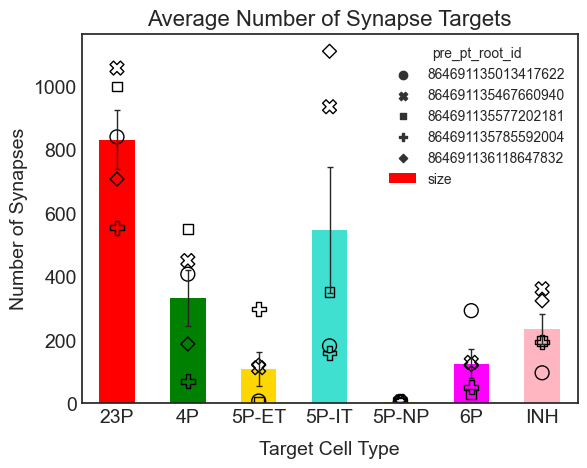

In [72]:
###get IDs for each predicted MET-type
met8_pred = df_ids_pred_met.loc[df_ids_pred_met['predicted_MET-type Label'] == "Sst-MET-8"]
met8_id = met8_pred["id"]

met4_pred = df_ids_pred_met.loc[df_ids_pred_met['predicted_MET-type Label'] == "Sst-MET-4"]
met4_id = met4_pred["id"]

met6_pred = df_ids_pred_met.loc[df_ids_pred_met['predicted_MET-type Label'] == "Sst-MET-6"]
met6_id = met6_pred["id"]

###filter dfm somas by each met-type
met8 = dfm_somas[dfm_somas.pre_pt_root_id.isin(met8_id)]
met4 = dfm_somas[dfm_somas.pre_pt_root_id.isin(met4_id)]
met6 = dfm_somas[dfm_somas.pre_pt_root_id.isin(met6_id)]


### count # of synapses onto each cell type by MET type
met8_pre_celltypes = met8.groupby(['pre_pt_root_id', 'cell_type'], dropna = False, as_index = False).size()
met4_pre_celltypes = met4.groupby(['pre_pt_root_id', 'cell_type'], dropna = False, as_index = False).size()
met6_pre_celltypes = met6.groupby(['pre_pt_root_id', 'cell_type'], dropna = False, as_index = False).size()
d = {'pre_pt_root_id': [864691135058985115], 'cell_type': ['5P-NP'],  'size':[0]}
add0 = pd.DataFrame(data = d)
met6_pre_celltypes = pd.concat([met6_pre_celltypes, add0]) 

met8_pre_celltypes = met8_pre_celltypes.sort_values(by = ['pre_pt_root_id', 'cell_type'])
met4_pre_celltypes = met4_pre_celltypes.sort_values(by = ['pre_pt_root_id', 'cell_type'])
met6_pre_celltypes = met6_pre_celltypes.sort_values(by = ['pre_pt_root_id', 'cell_type'])


###calc mean # of syn onto cell types by MET type
met8_no_mean =met8_pre_celltypes.groupby('cell_type', as_index = False).mean()
met8_no_sem =met8_pre_celltypes.groupby('cell_type', as_index = False).sem()
met8_no_mean['sem'] = met8_no_sem['size']

met4_no_mean =met4_pre_celltypes.groupby('cell_type', as_index = False).mean()
met4_no_sem =met4_pre_celltypes.groupby('cell_type', as_index = False).sem()
met4_no_mean['sem'] = met4_no_sem['size']

met6_no_mean =met6_pre_celltypes.groupby('cell_type', as_index = False).mean()
met6_no_sem =met6_pre_celltypes.groupby('cell_type', as_index = False).sem()
met6_no_mean['sem'] = met6_no_sem['size']


###plot number of synapses onto each cell type

##plotting cell with n > 1, so can calc SEM
plotting_met_mean = met4_no_mean
plotting_met_all = met4_pre_celltypes
with plt.style.context('seaborn-white', after_reset = True):
    afont = {'fontname':'Arial'}
    fig = plt.figure()
    my_color = ["red", "green", "gold", "turquoise", "orange", "magenta", "lightpink"]

    ####number of syn
    ax = plotting_met_mean.plot(kind = 'bar', x = 'cell_type', y = 'size', color = my_color, linewidth = 3, yerr = 'sem', error_kw=dict(lw=1, capsize=2, capthick=1))
    sns.scatterplot(x = "cell_type", y = "size", style = "pre_pt_root_id", data = plotting_met_all, edgecolor = "black", linewidth = 1, s = 100, color = 'None', ax = ax)
    ax.set_ylabel('Number of Synapses', fontsize =14, **afont)
    plt.title('Average Number of Synapse Targets', fontsize = 16, **afont)
    ax.set_xlabel('Target Cell Type', fontsize =14, **afont)
    plt.xticks (fontsize =14, rotation = 0, **afont)
    plt.yticks (fontsize =14, **afont, visible = True)
#     ax.get_legend().remove()
    ax.xaxis.labelpad = 10
#     plt.savefig('__.png', bbox_inches = 'tight')

    plt.show()
    

met_type          MET8   MET4        MET6
cell_type                                
23P        1171.666667  831.4  601.333333
4P         5622.666667  332.4  115.333333
5P-ET        60.333333  108.0  332.000000
5P-IT      1288.333333  547.0  155.666667
5P-NP         4.000000    4.0    2.000000
6P          128.000000  124.6  152.333333
INH         771.000000  233.8  151.666667


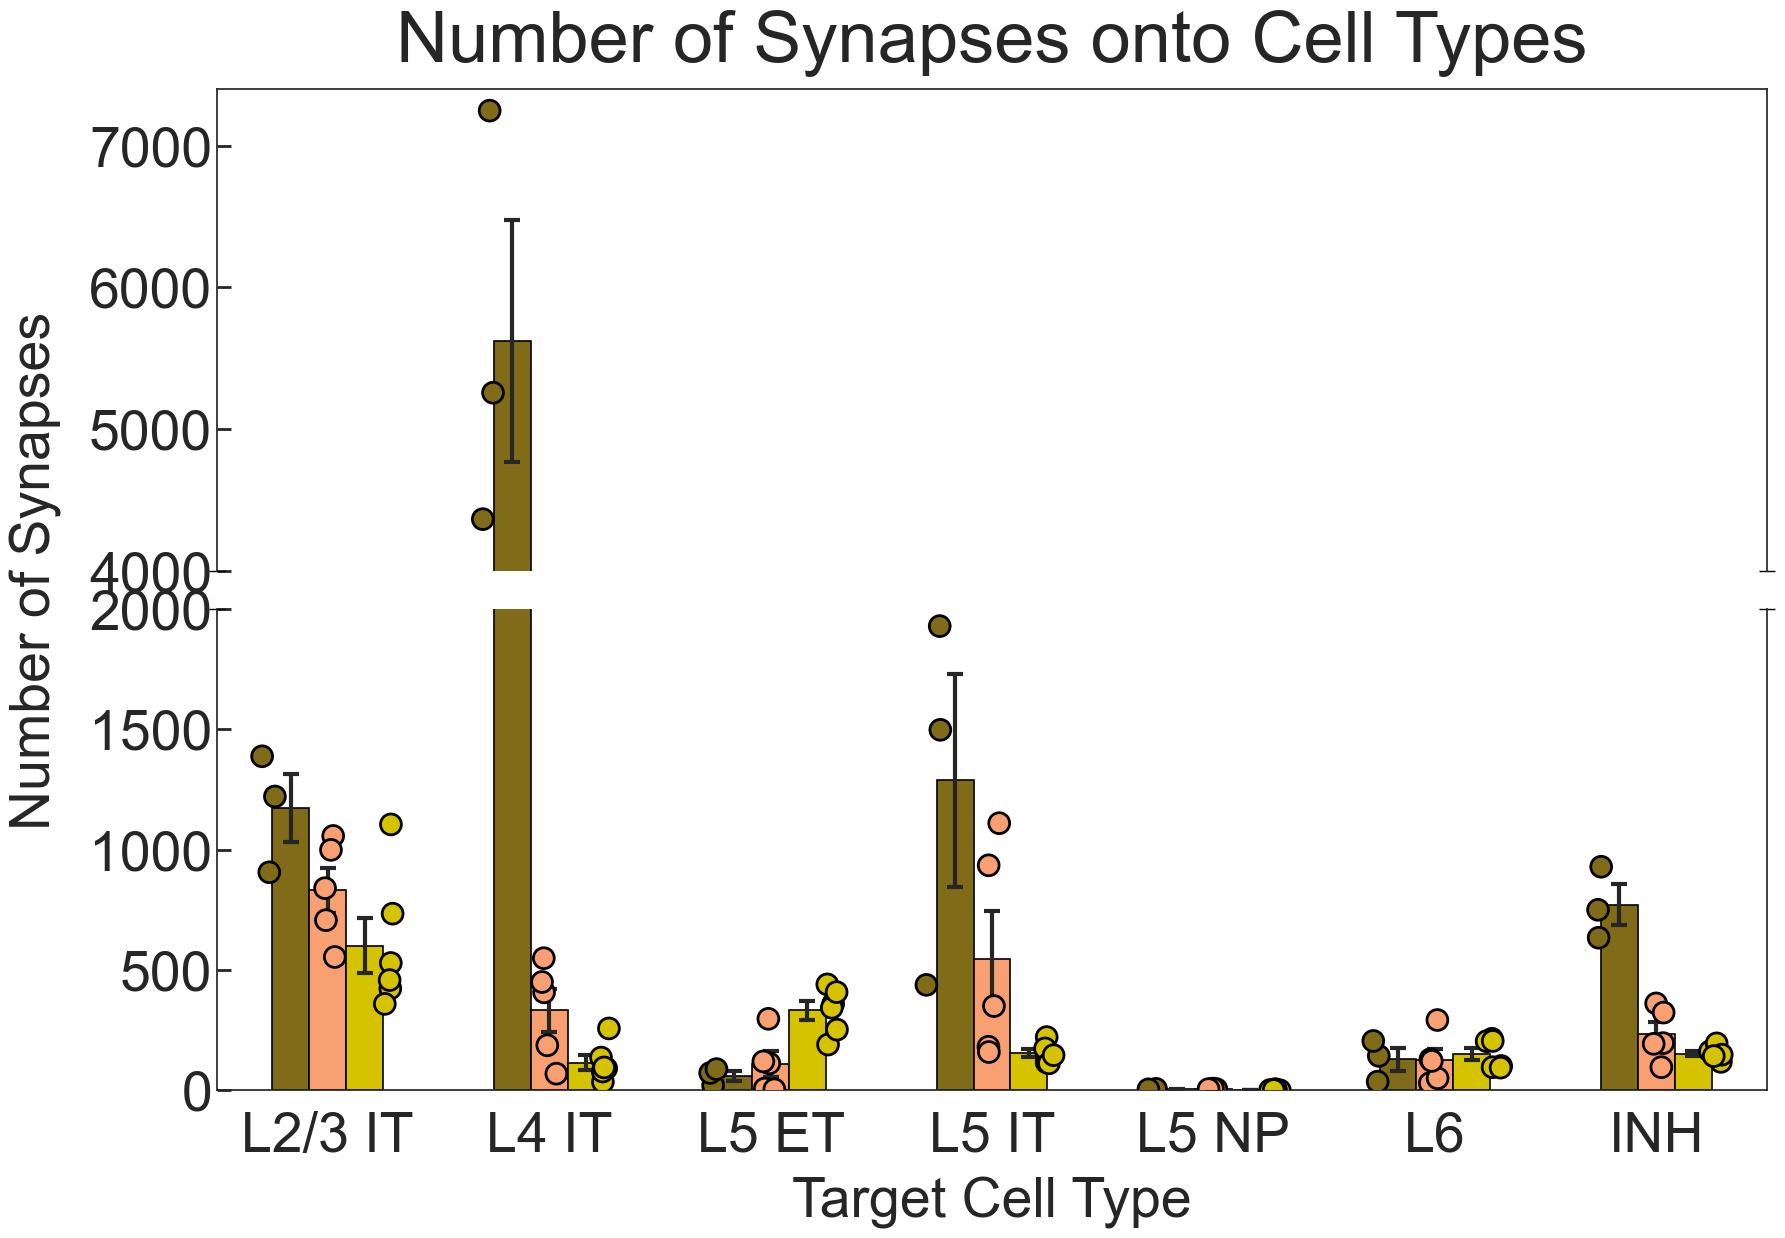

In [74]:
####comparing total syn onto group across MET types -single plot (all MET types n > 1)

##note all of these cells as MET-type
met8_pre_celltypes["met_type"] = "MET8"
met4_pre_celltypes["met_type"] = "MET4"
met6_pre_celltypes["met_type"] = "MET6"

##merge into one table for calculating % and # of syn onto cell types
met846_celltypes = pd.concat([met8_pre_celltypes, met4_pre_celltypes, met6_pre_celltypes])

###number of synapses met 846
met846_mean =met846_celltypes.groupby(['cell_type', 'met_type'], as_index = False)['size'].mean()
met846_sem =met846_celltypes.groupby(['cell_type', 'met_type'], as_index = False)['size'].sem()
met846_mean['sem'] = met846_sem['size']
# print (met846_mean)
met846_mean_table = pd.pivot(met846_mean, values = 'size', index = ['cell_type'], columns =['met_type'])
met846_mean_table = met846_mean_table[["MET8", "MET4", "MET6"]]
# met846_mean_table = met846_mean_table.reset_index()
print (met846_mean_table)
met846_sem_table = pd.pivot(met846_mean, values = 'sem', index = ['cell_type'], columns =['met_type'])
met846_sem_table = met846_sem_table[["MET8", "MET4", "MET6"]]



with plt.style.context('seaborn-white', after_reset = True):
    fig, (ax10, ax20) = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0.08)  # adjust space between axes
    fig.set_figwidth(20)
    fig.set_figheight(13)
    afont = {'fontname':'Arial'}
    met_color = ['#806B19', '#f9a072','#D6C300', '#FFDF11']

    ###percent of syn
#     plt.rcParams['figure.figsize'] = [5, 3.6]

    met846_mean_table.plot(kind = 'bar', linewidth = 1.2, edgecolor = 'black', color = met_color , yerr = met846_sem_table, error_kw=dict(lw=3, capsize=6, capthick=3), legend = False, ax = ax10)
    met846_mean_table.plot(kind = 'bar', linewidth = 1.2, edgecolor = 'black', color = met_color , yerr = met846_sem_table, error_kw=dict(lw=3, capsize=6, capthick=3), legend = False, ax = ax20)

    sns.stripplot(x = "cell_type", y = "size", hue = "met_type", data = met846_celltypes, palette = met_color, edgecolor = "black", dodge = True, linewidth = 2, s = 15, marker = "o", ax = ax10)   
    sns.stripplot(x = "cell_type", y = "size", hue = "met_type", data = met846_celltypes, palette = met_color, edgecolor = "black", dodge = True, linewidth = 2, s = 15, marker = "o", ax = ax20)   
    ax10.set_ylim(4000, 7400)  # outliers only
    ax20.set_ylim(0, 2000)  # most of the data

    # hide the spines between ax and ax2
    ax10.spines['bottom'].set_visible(False)
    ax20.spines['top'].set_visible(False)
    ax10.xaxis.tick_top()
    ax10.tick_params(labeltop=False)  # don't put tick labels at the top
    ax20.xaxis.tick_bottom()
    d = 0  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax10.plot([0, 1], [0, 0], transform=ax10.transAxes, **kwargs)
    ax20.plot([0, 1], [1, 1], transform=ax20.transAxes, **kwargs)
    ax10.set_title('Number of Synapses onto Cell Types', fontsize = 52, **afont, pad = 20)
    ax10.set_ylabel('Number of Synapses', fontsize =40, **afont)
    ax10.yaxis.set_label_coords(-.1, 0)
    ax20.set_ylabel('', fontsize =40, **afont)

    ax20.set_xlabel('Target Cell Type', fontsize =40, **afont)
    ax20.xaxis.labelpad = 10
    plt.xticks (fontsize =40, rotation = 0, **afont)
    plt.sca(ax10)
    plt.yticks (fontsize = 40,  **afont)
    plt.sca(ax20)
    plt.yticks (fontsize =40,  **afont)
    ax10.yaxis.labelpad = 10

#     ax20.set_xticklabels(["23P", "4P", "5P-IT", "5P-NP", "5P-ET", "6P", "INH"])
    ax10.tick_params('y', length=10, width=2, which='major', direction = "in")
    ax20.tick_params('y', length=10, width=2, which='major', direction = "in")
    ax10.yaxis.set_major_locator(MultipleLocator(1000))
    ax10.yaxis.set_major_formatter('{x:.0f}')
    ax20.yaxis.set_major_locator(MultipleLocator(500))
    ax20.yaxis.set_major_formatter('{x:.0f}')
    ax10.get_legend().remove()
    ax20.get_legend().remove()
    ax10.set_xticklabels(["L2/3 IT", "L4 IT", "L5 ET", "L5 IT", "L5 NP", "L6", "INH"])
    ax20.tick_params(axis='x', which='major', pad=15)

#     plt.savefig('____.pdf', bbox_inches = 'tight')



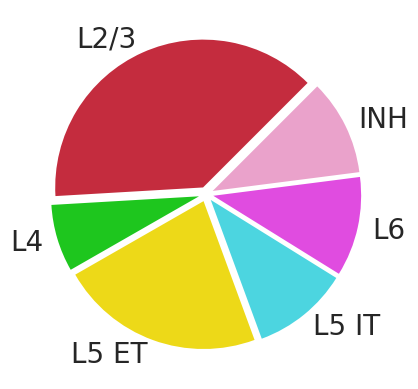

In [75]:
##calculate percentage & sem for each predicted met type

met8_pre_celltypes['percent'] = met8_pre_celltypes['size']/met8_pre_celltypes.groupby('pre_pt_root_id')['size'].transform('sum')
met8_syn_per_mean =met8_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].mean()
met8_syn_per_sem =met8_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].sem()
met8_syn_per_mean['sem'] = met8_syn_per_sem['percent']

met4_pre_celltypes['percent'] = met4_pre_celltypes['size']/met4_pre_celltypes.groupby('pre_pt_root_id')['size'].transform('sum')
met4_syn_per_mean =met4_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].mean()
met4_syn_per_sem =met4_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].sem()
met4_syn_per_mean['sem'] = met4_syn_per_sem['percent']

met6_pre_celltypes['percent'] = met6_pre_celltypes['size']/met6_pre_celltypes.groupby('pre_pt_root_id')['size'].transform('sum')
met6_syn_per_mean =met6_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].mean()
met6_syn_per_sem =met6_pre_celltypes.groupby(['cell_type'], as_index = False)['percent'].sem()
met6_syn_per_mean['sem'] = met6_syn_per_sem['percent']

### plot percentage of synapses by MET-type (change met type below)
plotting_met_mean = met6_syn_per_mean


plotting_met_mean = plotting_met_mean.loc[plotting_met_mean['cell_type'] != '5P-NP']
with plt.style.context('seaborn-white', after_reset = True):
    afont = {'fontname':'Arial'}
    fig = plt.figure()
    label = ["L2/3", "L4", "L5 ET", "L5 IT", "L6", "INH"]
# #     order1 = ["23P", "4P", "5P_IT", "5P_NP", "5P_PT", "6P", "INH"]
    my_color = ["red", "green", "gold", "turquoise", "magenta", "lightpink"]
    muted_colors2 = ['#C42C3E','#1EC61E','#EDD918', '#4CD5E0', '#E04CE0', '#EAA2CB']
    plt.pie(plotting_met_mean['percent'], startangle = 45, explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05], colors= muted_colors2, wedgeprops={'alpha':1}, labels =label, textprops={'fontsize': 20}, pctdistance = 0.70)
#     plt.savefig('___.pdf', bbox_inches = 'tight', transparent = True)


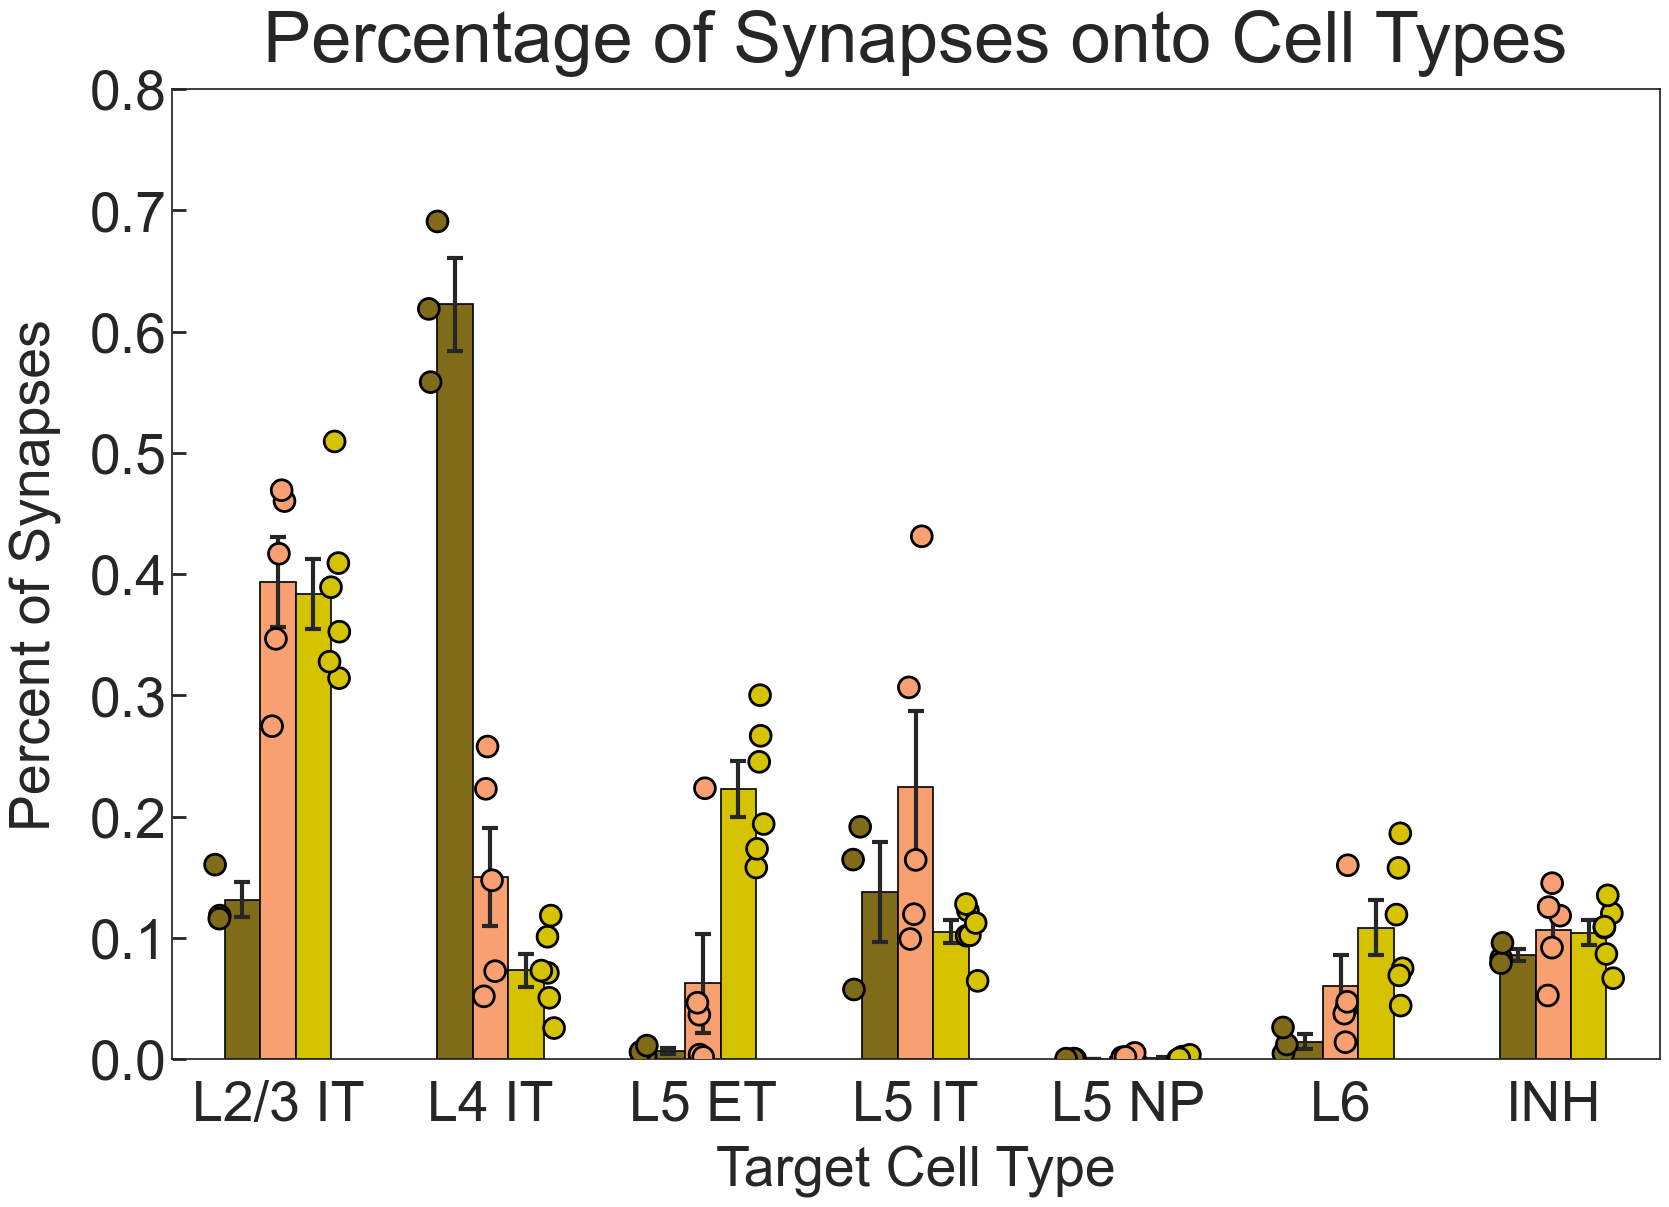

In [76]:
####comparing % and total syn onto group across MET types -single plot

##note all of these cells as MET-type
met8_pre_celltypes["met_type"] = "MET8"
met4_pre_celltypes["met_type"] = "MET4"
met6_pre_celltypes["met_type"] = "MET6"
met5_pre_celltypes["met_type"] = "MET5"
##merge into one table for calculating % and # of syn onto cell types
met846_celltypes = pd.concat([met8_pre_celltypes, met4_pre_celltypes, met6_pre_celltypes])

# ###percentage of syn
met846_mean =met846_celltypes.groupby(['cell_type', 'met_type'], as_index = False)['percent'].mean()
met846_sem =met846_celltypes.groupby(['cell_type', 'met_type'], as_index = False)['percent'].sem()
met846_mean['sem'] = met846_sem['percent']

met846_per_mean_table = pd.pivot(met846_mean, values = 'percent', index = ['cell_type'], columns =['met_type'])
met846_per_mean_table = met846_per_mean_table[["MET8", "MET4", "MET6"]]
met846_per_mean_table = met846_per_mean_table.reset_index()
met846_per_sem_table = pd.pivot(met846_mean, values = 'sem', index = ['cell_type'], columns =['met_type'])
met846_per_sem_table = met846_per_sem_table[["MET8", "MET4", "MET6"]]
met846_per_sem_table = met846_per_sem_table.reset_index()

with plt.style.context('seaborn-white', after_reset = True):
    fig, ax = plt.subplots()
    fig.set_figwidth(19.2)
    fig.set_figheight(12.6)
    afont = {'fontname':'Arial'}

    met_color = ['#806B19', '#f9a072','#D6C300', '#FFDF11']
    met846_per_mean_table.plot(kind = 'bar', linewidth = 1.2, edgecolor = 'black', color = met_color, yerr = met846_per_sem_table, error_kw=dict(lw=3, capsize=6, capthick=3), legend = False, ax = ax)
    sns.stripplot(x = "cell_type", y = "percent", hue = "met_type", data = met846_celltypes, palette = met_color, edgecolor = "black", dodge = True, linewidth = 2, s = 15, marker = "o", ax = ax)   

    ax.set_ylabel('Percent of Synapses', fontsize =40, **afont)
    plt.ylim(0, 0.8)    
    plt.title('Percentage of Synapses onto Cell Types', fontsize = 52, **afont, pad = 20)
    ax.set_xlabel('Target Cell Type', fontsize =40, **afont)
    plt.xticks (fontsize =40, rotation = 0, **afont)
    ax.tick_params('y', length=10, width=2, which='major', direction = "in")
    ax.set_xticklabels(["L2/3 IT", "L4 IT", "L5 ET", "L5 IT", "L5 NP", "L6", "INH"])

    plt.yticks (fontsize =40, **afont, visible = True)
    ax.get_legend().remove()
    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 20
    ax.tick_params(axis='x', which='major', pad=15)
#     plt.savefig('____.pdf', bbox_inches = 'tight', transparent = 'True')


In [77]:
###STATS
####stats comparing % and # onto cell types by MET type

cell_list = ["23P", "4P",  "5P-ET", "5P-IT", "5P-NP", "6P", "INH"]
for x in range(len(cell_list)):
    print(cell_list[x])
    cell_type_x = met846_celltypes.loc[met846_celltypes['cell_type'] == cell_list[x]]

    cell_type_8 = cell_type_x.loc[cell_type_x['met_type'] == "MET8"]
    cell_type_4 = cell_type_x.loc[cell_type_x['met_type'] == "MET4"]
    cell_type_6 = cell_type_x.loc[cell_type_x['met_type'] == "MET6"]

#     ###percent
    met8_per = cell_type_8['percent']
    np_met8 = met8_per.to_numpy()
#     print (np_met8)
    met4_per = cell_type_4['percent']
    np_met4 = met4_per.to_numpy()
#     print (np_met4)
    met6_per = cell_type_6['percent']
    np_met6 = met6_per.to_numpy()
#     print (np_met6)


    ###size/number of synapses
#     met8_per = cell_type_8['size']
#     np_met8 = met8_per.to_numpy()
# #     print (np_met8)
#     met4_per = cell_type_4['size']
#     np_met4 = met4_per.to_numpy()
# #     print (np_met4)
#     met6_per = cell_type_6['size']
#     np_met6 = met6_per.to_numpy()
# #     print (np_met6)

###846    
    stats1 = stats.kruskal(np_met8, np_met4, np_met6)
    print (stats1)
    stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
    print (stats2)



23P
KruskalResult(statistic=6.683809523809522, pvalue=0.0353695229984442)
          1        2         3
1  1.000000  0.02552  0.037948
2  0.025520  1.00000  1.000000
3  0.037948  1.00000  1.000000
4P
KruskalResult(statistic=7.940952380952375, pvalue=0.01886444792554498)
          1         2         3
1  1.000000  0.073244  0.004816
2  0.073244  1.000000  0.347266
3  0.004816  0.347266  1.000000
5P-ET
KruskalResult(statistic=7.750476190476185, pvalue=0.02074939695291045)
          1         2         3
1  1.000000  1.000000  0.012761
2  1.000000  1.000000  0.031087
3  0.012761  0.031087  1.000000
5P-IT
KruskalResult(statistic=2.2266666666666595, pvalue=0.32846226005543605)
     1         2         3
1  1.0  1.000000  1.000000
2  1.0  1.000000  0.493581
3  1.0  0.493581  1.000000
5P-NP
KruskalResult(statistic=3.588571428571427, pvalue=0.16624615720233948)
          1        2         3
1  1.000000  0.20214  0.468049
2  0.202140  1.00000  1.000000
3  0.468049  1.00000  1.000000
6P
Krusk

In [78]:
###statistics of synapse size, number, and *area* by predicted MET type
###find average # (mean) and total number (count) of output synapses by met type
met8_syn_grouped= met8.groupby("pre_pt_root_id")
met8sort =met8.sort_values(by = ['size'], ascending = False)
# print (met8sort)
met8_syn_mean = met8_syn_grouped.mean()
met8_syn_count = met8_syn_grouped.count()
met8_syn_mean['met'] = "MET8"
met8_syn_count['met'] = "MET8"

met4_syn_grouped= met4.groupby("pre_pt_root_id")
met4_syn_mean = met4_syn_grouped.mean()
met4_syn_count = met4_syn_grouped.count()
met4_syn_mean['met'] = "MET4"
met4_syn_count['met'] = "MET4"


met6_syn_grouped= met6.groupby("pre_pt_root_id")
met6_syn_mean = met6_syn_grouped.mean()
met6_syn_count = met6_syn_grouped.count()
met6_syn_mean['met'] = "MET6"
met6_syn_count['met'] = "MET6"


###concat all cells mean and counts together
allcell_mean = pd.concat([met8_syn_mean, met4_syn_mean, met6_syn_mean])
allcell_count = pd.concat([met8_syn_count, met4_syn_count, met6_syn_count])

### calculate average and sem of synapse size by met type
allcell_mean = allcell_mean.sort_values(by=['met'])
mean_group = allcell_mean.groupby("met")
mean_mean = mean_group.mean()
mean_sem = mean_group.sem()
mean_mean['size_sem'] = mean_sem['size']
mean_mean = mean_mean.reindex(["MET8", "MET4", "MET6"])
print ('This is the mean synapse size')
print(mean_mean)

### calculate average and sem of synapze count by met type
allcell_count = allcell_count.sort_values(by=['met'])
count_group = allcell_count.groupby("met")
count_mean = count_group.mean()
count_sem = count_group.sem()
count_mean['count_sem'] = count_sem['size']
count_mean = count_mean.reindex(["MET8", "MET4", "MET6"])
print('This is the synapse count')
print(count_mean)

##find sum of synapse "size" onto each postsynaptic target by presynaptic cell
met8_group = met8.groupby(['pre_pt_root_id', 'post_pt_root_id', 'cell_type'], dropna = False, as_index = False).sum()
met4_group = met4.groupby(['pre_pt_root_id', 'post_pt_root_id', 'cell_type'], dropna = False, as_index = False).sum()
met6_group = met6.groupby(['pre_pt_root_id', 'post_pt_root_id', 'cell_type'], dropna = False, as_index = False).sum()

##note all of these cells as MET-type
met8_group["met_type"] = "MET8"
met4_group["met_type"] = "MET4"
met6_group["met_type"] = "MET6"

###find mean synapse size onto target (size = avg synapse "area"/target, somas = avg # of syn/target)
avg_met8_groupsyn = met8_group.groupby(['pre_pt_root_id'], dropna = False, as_index = False).mean()
avg_met4_groupsyn = met4_group.groupby(['pre_pt_root_id'], dropna = False, as_index = False).mean()
avg_met6_groupsyn = met6_group.groupby(['pre_pt_root_id'], dropna = False, as_index = False).mean()

##note all of these cells as MET-type
avg_met8_groupsyn["met_type"] = "MET8"
avg_met4_groupsyn["met_type"] = "MET4"
avg_met6_groupsyn["met_type"] = "MET6"

##merge into one table for calculating % and # of syn onto cell types
met846_synbytarget = pd.concat([avg_met8_groupsyn, avg_met4_groupsyn, avg_met6_groupsyn])

# all_met846_synbytarget = pd.concat([met8_group, met4_group, met6_group])

# print (met846_synbytarget)

# sum_target_group = met8465_synbytarget.groupby("met_type")
sum_target_group = met846_synbytarget.groupby("met_type")
sum_target_mean = sum_target_group.mean()
sum_target_sem = sum_target_group.sem()
sum_target_mean['target_sem'] = sum_target_sem['size']
sum_target_mean = sum_target_mean.reindex(["MET8", "MET4", "MET6"])
print ('this is the avg sum of synapse size onto target/met type')
print (sum_target_mean)

sum_target_mean_syn = sum_target_mean
sum_target_mean_syn['target_syn_sem'] = sum_target_sem['no_of_somas']
print ('this is the avg sum of synapse number onto target/met type')
print (sum_target_mean_syn)

This is the mean synapse size
              id_x  pre_pt_supervoxel_id  post_pt_supervoxel_id  \
met                                                               
MET8  1.690987e+08          8.991809e+16           8.991798e+16   
MET4  1.609139e+08          8.928168e+16           8.928161e+16   
MET6  1.951463e+08          9.205015e+16           9.205018e+16   

      post_pt_root_id         size           id_y  pt_supervoxel_id  \
met                                                                   
MET8     8.646911e+17  2668.321964  283752.499167      8.991639e+16   
MET4     8.646911e+17  3924.384897  276999.881927      8.957224e+16   
MET6     8.646911e+17  3382.739355  320555.645057      9.227547e+16   

        pt_root_id  no_of_somas    size_sem  
met                                          
MET8  8.646911e+17          1.0   95.200064  
MET4  8.646911e+17          1.0  237.601699  
MET6  8.646911e+17          1.0   61.392143  
This is the synapse count
             id_x     

In [79]:
###statistics comparing synapse number, size, sum across MET types
##synapse number
print ("average number of output synapses/cell")
mean_met8 = allcell_count.loc[allcell_count['met'] == 'MET8']
mean_met8_size = mean_met8['size']
np_met8 = mean_met8_size.to_numpy()
print (np_met8)
print (np_met8.mean())
mean_met4 = allcell_count.loc[allcell_count['met'] == 'MET4']
mean_met4_size = mean_met4['size']
np_met4 = mean_met4_size.to_numpy()
print (np_met4.mean())
mean_met6 = allcell_count.loc[allcell_count['met'] == 'MET6']
mean_met6_size = mean_met6['size']
np_met6 = mean_met6_size.to_numpy()
print (np_met6.mean())
print (np_met6)

stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2) 

##synapse size
print ("average output synapse size/cell")
mean_met8 = allcell_mean.loc[allcell_mean['met'] == 'MET8']
mean_met8_size = mean_met8['size']
np_met8 = mean_met8_size.to_numpy()
print (np_met8.mean())

mean_met4 = allcell_mean.loc[allcell_mean['met'] == 'MET4']
mean_met4_size = mean_met4['size']
np_met4 = mean_met4_size.to_numpy()
# print (np_met4)
mean_met6 = allcell_mean.loc[allcell_mean['met'] == 'MET6']
mean_met6_size = mean_met6['size']
np_met6 = mean_met6_size.to_numpy()
print (np_met6)

stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)




### avg # of synapse/contact =  convergence
print ("average number of synapses/connection")
mean_met8 = met846_synbytarget.loc[met846_synbytarget['met_type'] == 'MET8']
mean_met8_size = mean_met8['no_of_somas']
np_met8 = mean_met8_size.to_numpy()
# print (np_met8)
mean_met4 = met846_synbytarget.loc[met846_synbytarget['met_type'] == 'MET4']
mean_met4_size = mean_met4['no_of_somas']
np_met4 = mean_met4_size.to_numpy()
# print (np_met4)
mean_met6 = met846_synbytarget.loc[met846_synbytarget['met_type'] == 'MET6']
mean_met6_size = mean_met6['no_of_somas']
np_met6 = mean_met6_size.to_numpy()
print (np_met6)
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)





average number of output synapses/cell
[ 7608 11716  7814]
9046.0
2181.2
1510.3333333333333
[1346 2169 1794 1359 1095 1299]
KruskalResult(statistic=8.297142857142859, pvalue=0.015786953173634915)
          1         2         3
1  1.000000  0.073666  0.003218
2  0.073666  1.000000  0.215198
3  0.003218  0.215198  1.000000
average output synapse size/cell
2668.3219637997304
[3127.25705795 3313.95666206 3393.21516165 3506.73142016 3546.82009132
 3408.45573518]
KruskalResult(statistic=10.140952380952378, pvalue=0.006279429224342137)
          1         2         3
1  1.000000  0.000212  0.025139
2  0.000212  1.000000  0.010671
3  0.025139  0.010671  1.000000
average number of synapses/connection
[1.5705951  1.57630814 1.50756303 1.4723727  1.44649934 1.40584416]
KruskalResult(statistic=7.12380952380952, pvalue=0.028384707081217715)
          1         2         3
1  1.000000  0.063417  0.012012
2  0.063417  1.000000  1.000000
3  0.012012  1.000000  1.000000


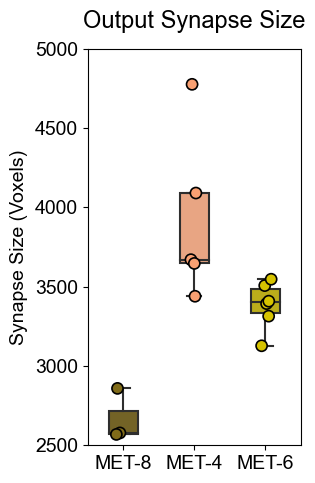

In [80]:
###plotting synapse size/number/connection differences
plt.rcParams["figure.figsize"] = (2.75,5.15)

met_color = ['#806B19', '#f9a072','#D6C300', '#FFDF11']
ordermet = ["MET8", "MET4", "MET6"]
afont = {'fontname':'Arial'}

ax =sns.boxplot(x = "met", y = "size", palette = met_color, data = allcell_mean,width = 0.4, order = ordermet)
sns.stripplot(x = "met", y = "size", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = allcell_mean, marker = 'o', ax = ax, order = ordermet)


plt.title('Output Synapse Size', fontsize = 17, **afont, pad = 15)
ax.set_ylabel('Synapse Size (Voxels)', fontsize = 14, **afont)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])
plt.ylim(2500, 5000)
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5

# plt.rcParams["figure.figsize"] = (3.3,4.95)
t = ax.yaxis.get_offset_text()
t.set_size(14)

# plt.savefig('____.pdf', bbox_inches = 'tight', transparent = 'True')

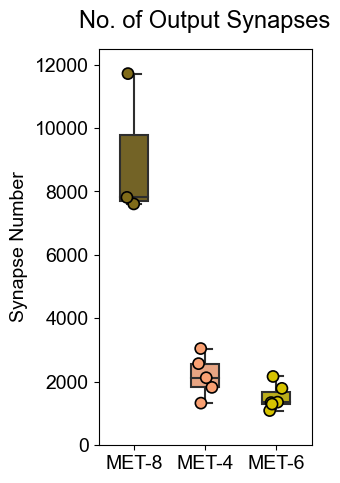

In [81]:
plt.rcParams["figure.figsize"] = (2.75,5.15)

met_color = ['#806B19', '#f9a072','#D6C300', '#FFDF11']
ax =sns.boxplot(x = "met", y = "size", palette = met_color, data = allcell_count, width = 0.4, order = ordermet)
sns.stripplot(x = "met", y = "size", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = allcell_count, marker = 'o', ax = ax, order = ordermet)


afont = {'fontname':'Arial'}
plt.title('No. of Output Synapses', fontsize = 17, **afont, pad = 15)
ax.set_ylabel('Synapse Number', fontsize = 14, **afont)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.ylim(0, 12500)
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5

t = ax.yaxis.get_offset_text()
t.set_size(14)

# plt.savefig('___.pdf', bbox_inches = 'tight', transparent = 'True')

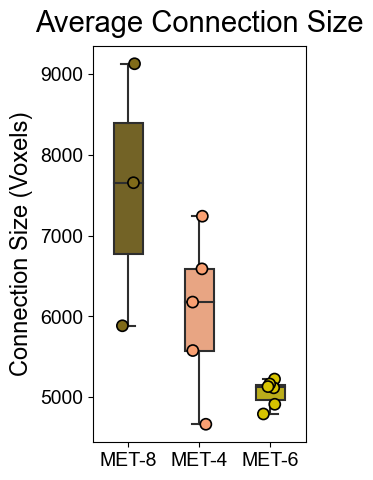

In [82]:
plt.rcParams["figure.figsize"] = (2.75,5.15)

met_color = ['#806B19', '#f9a072','#D6C300', '#FFDF11']
ax =sns.boxplot(x = "met_type", y = "size", palette = met_color, data = met846_synbytarget, width = 0.4,order = ordermet)
sns.stripplot(x = "met_type", y = "size", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = met846_synbytarget, marker = 'o', ax = ax, order = ordermet)


afont = {'fontname':'Arial'}
plt.title('Average Connection Size', fontsize = 21, **afont, pad = 10)
ax.set_ylabel('Connection Size (Voxels)', fontsize = 17, **afont)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5

t = ax.yaxis.get_offset_text()
t.set_size(20)

# plt.savefig('__.pdf', bbox_inches = 'tight')

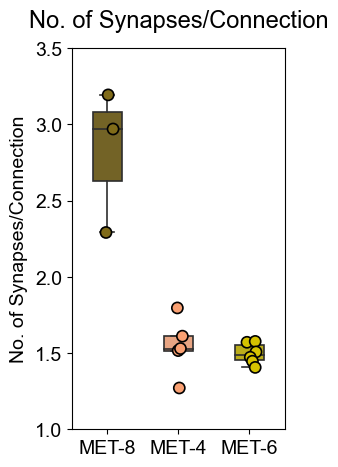

In [83]:
plt.rcParams["figure.figsize"] = (2.75,4.95)

met_color = ['#806B19', '#f9a072','#D6C300', '#FFDF11']
ax =sns.boxplot(x = "met_type", y = "no_of_somas", palette = met_color, linewidth = 1.2, data = met846_synbytarget, width = 0.4,order = ordermet)
sns.stripplot(x = "met_type", y = "no_of_somas", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = met846_synbytarget, marker = 'o', ax = ax, order = ordermet)

afont = {'fontname':'Arial'}
plt.title('No. of Synapses/Connection', fontsize = 17, **afont, pad = 15)
ax.set_ylabel('No. of Synapses/Connection', fontsize = 14, **afont)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.ylim(1, 3.5)

plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5

t = ax.yaxis.get_offset_text()
t.set_size(14)

# plt.savefig('CG_Met846_avg_cxn_syn_bigbatch_1114.pdf', bbox_inches = 'tight', transparent = 'True')

In [84]:
myelin_df = pd.read_csv("./mye_annot_ids.csv")
myelin_df_sub = myelin_df[["Coordinate_1", "Coordinate_2", "mesh_id", "met_type"]].copy()
myelin_df_sub['Coordinate_1'] = myelin_df_sub.Coordinate_1.apply(lambda x: literal_eval(str(x)))
myelin_df_sub['Coordinate_2'] = myelin_df_sub.Coordinate_2.apply(lambda x: literal_eval(str(x)))
myelin_df_sub['mesh_id_full'] = myelin_df_sub['mesh_id'].str.rstrip(',')

data1 = myelin_df_sub[['mesh_id_full', "met_type"]].drop_duplicates()
coord1_np = np.stack(myelin_df_sub["Coordinate_1"].to_numpy())
coord2_np = np.stack(myelin_df_sub["Coordinate_2"].to_numpy())
coord1_um = coord1_np*[.004,.004,.04]
coord2_um = coord2_np*[.004,.004,.04]
distum = np.linalg.norm(coord1_um - coord2_um ,axis=1)
myelin_df_sub['euc_dist_um'] = distum


##number of segments
mye_id_size = myelin_df_sub.groupby(['mesh_id_full', 'met_type']).size().reset_index()
mye_id_size =mye_id_size.rename(columns={0: "count"})
add0_mye = {'mesh_id_full': '864691136116457636', 'met_type': 'MET6', 'count': 0}
mye_id_size = mye_id_size.append(add0_mye, ignore_index = True)
# print (mye_id_size)

##total length of segments
mye_id_sum =  myelin_df_sub.groupby(['mesh_id_full', 'met_type']).sum().reset_index()
add0_mye_sum = {'mesh_id_full': '864691136116457636', 'met_type': 'MET6', 'euc_dist_um': 0}
mye_id_sum = mye_id_sum.append(add0_mye_sum, ignore_index = True)
# print (mye_id_sum)

###avg length of segment
mye_id_avg =  myelin_df_sub.groupby(['mesh_id_full', 'met_type']).mean().reset_index()
# print (mye_id_avg)


# ###max y-extent of segments
mesh_id_list = ["864691135544588584",
"864691135577202181",
"864691135785592004",
"864691135988665856",
"864691135467660940",
"864691135925834510",
"864691135754152141",
"864691136118647832",
"864691135699487522",
"864691136618564493",
"864691135013417622",
"864691135118298333",
"864691135374222153",
"864691135058985115",
"864691135341516741"]


In [85]:
####statistics of myelin segment number and y-extent by met type

# ###segment number
print ("segment number stats")
mean_met8 = mye_id_size.loc[mye_id_size['met_type'] == 'MET8']
mean_met8_size = mean_met8['count']
np_met8 = mean_met8_size.to_numpy()
print (np_met8)
mean_met4 = mye_id_size.loc[mye_id_size['met_type'] == 'MET4']
mean_met4_size = mean_met4['count']
np_met4 = mean_met4_size.to_numpy()
print (np_met4)
mean_met6 = mye_id_size.loc[mye_id_size['met_type'] == 'MET6']
mean_met6_size = mean_met6['count']
np_met6 = mean_met6_size.to_numpy()
print (np_met6)
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)

# # ###length
print ("length of myelin stats")

mean_met8 = mye_id_sum.loc[mye_id_sum['met_type'] == 'MET8']
mean_met8_size = mean_met8['euc_dist_um']
np_met8 = mean_met8_size.to_numpy()
print (np_met8)
mean_met4 = mye_id_sum.loc[mye_id_sum['met_type'] == 'MET4']
mean_met4_size = mean_met4['euc_dist_um']
np_met4 = mean_met4_size.to_numpy()
print (np_met4)
mean_met6 = mye_id_sum.loc[mye_id_sum['met_type'] == 'MET6']
mean_met6_size = mean_met6['euc_dist_um']
np_met6 = mean_met6_size.to_numpy()
print (np_met6)
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)


### avg length of myelin
print ("avg length of myelin")

mean_met8 = mye_id_avg.loc[mye_id_avg['met_type'] == 'MET8']
mean_met8_size = mean_met8['euc_dist_um']
np_met8 = mean_met8_size.to_numpy()
print (np_met8)
mean_met4 = mye_id_avg.loc[mye_id_avg['met_type'] == 'MET4']
mean_met4_size = mean_met4['euc_dist_um']
np_met4 = mean_met4_size.to_numpy()
print (np_met4)
mean_met6 = mye_id_avg.loc[mye_id_avg['met_type'] == 'MET6']
mean_met6_size = mean_met6['euc_dist_um']
np_met6 = mean_met6_size.to_numpy()
print (np_met6)
stats1 = stats.kruskal(np_met8, np_met4, np_met6)
print (stats1)
stats2 = sp.posthoc_conover([np_met8, np_met4, np_met6], p_adjust = 'bonferroni')
print (stats2)

segment number stats
[1 6 1]
[11  6  8  7  6]
[1 2 1 4 1 0]
KruskalResult(statistic=8.889868522815156, pvalue=0.011737877637133916)
          1         2         3
1  1.000000  0.025767  1.000000
2  0.025767  1.000000  0.001848
3  1.000000  0.001848  1.000000
length of myelin stats
[ 21.45143911 163.10834826  21.35179056]
[348.2114798  276.18548408 220.39757974 165.65482408 288.90490776]
[ 28.57962155  34.6885744   21.69338406 109.93962454  19.73042726
   0.        ]
KruskalResult(statistic=9.028571428571425, pvalue=0.01095142478003731)
          1         2         3
1  1.000000  0.011834  1.000000
2  0.011834  1.000000  0.001924
3  1.000000  0.001924  1.000000
avg length of myelin
[21.45143911 27.18472471 21.35179056]
[31.65558907 46.03091401 27.54969747 23.66497487 48.15081796]
[28.57962155 17.3442872  21.69338406 27.48490614 19.73042726]
KruskalResult(statistic=5.520879120879123, pvalue=0.0632639539156324)
          1         2         3
1  1.000000  0.108733  1.000000
2  0.108733 

             count       sem
met_type                    
MET8      2.666667  1.666667
MET4      7.600000  0.927362
MET6      1.500000  0.562731


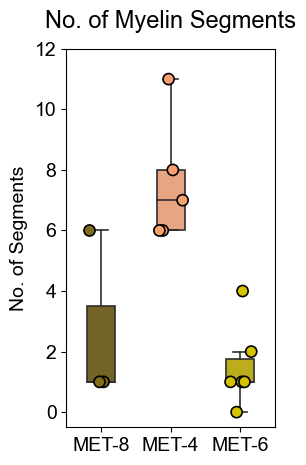

In [86]:
ordermet = ["MET8", "MET4", "MET6"]
plt.rcParams["figure.figsize"] = (2.95,4.75)

####number of myelin segment
seg_no_mean = mye_id_size.groupby('met_type').mean()
seg_no_sem = mye_id_size.groupby('met_type').sem()
seg_no_mean["sem"] = seg_no_sem["count"]
seg_no_mean = seg_no_mean.reindex(["MET8", "MET4", "MET6"])
print (seg_no_mean)



# # # # ####plot # of myelin segments
met_color = ['#806B19', '#f9a072','#D6C300']
met_colorcg = ['#8dd3c7','#ffffb3','#bebada']
plt.figure()

ax =sns.boxplot(x = "met_type", y = "count", palette = met_color, linewidth = 1.2, data = mye_id_size, width = 0.4, order = ordermet)
sns.stripplot(x = "met_type", y = "count", palette = met_color, edgecolor = "black", jitter = 0.2, linewidth = 1.2, s = 8, data = mye_id_size, marker = 'o', ax = ax, order = ordermet)

afont = {'fontname':'Arial'}
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax.set_xlabel('', fontsize = 14, **afont)
plt.ylim(-0.5, 12)
# ax.get_legend().remove()
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
t = ax.yaxis.get_offset_text()
t.set_size(14)
ax.set_xticklabels(["MET-8", "MET-4", "MET-6"])


ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 5



plt.title('No. of Myelin Segments', fontsize = 17, **afont, pad = 15)
ax.set_ylabel('No. of Segments', fontsize = 14, **afont)

plt.tight_layout()
# plt.savefig('Avg_met_reord_mye_no_seg_sem_17_metcolor_bbatch_1114.pdf', bbox_inches = 'tight', transparent = 'True')


          euc_dist_um        sem
met_type                        
MET8        68.637193  47.235587
MET4       259.870855  31.103062
MET6        35.771939  15.587298


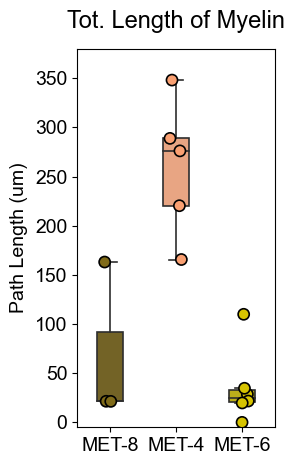

In [87]:
# ##########
# ###euclidean distance of myelin
euc_dist_mean = mye_id_sum.groupby('met_type').mean()
euc_dist_sem = mye_id_sum.groupby('met_type').sem()
euc_dist_mean["sem"] = euc_dist_sem["euc_dist_um"]
euc_dist_mean = euc_dist_mean.reindex(["MET8", "MET4", "MET6"])
print (euc_dist_mean)



# # # # # ####plot total length of myelin
plt.figure()
plt.rcParams["figure.figsize"] = (2.95,4.55)

ax2 =sns.boxplot(x = "met_type", y = "euc_dist_um", palette = met_color, data = mye_id_sum, linewidth = 1.2, width = 0.4, order = ordermet)
sns.stripplot(x = "met_type", y = "euc_dist_um", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = mye_id_sum, marker = 'o', ax = ax2, order = ordermet)

afont = {'fontname':'Arial'}
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax2.set_xlabel('', fontsize = 14, **afont)
# ax2.get_legend().remove()
ax2.xaxis.labelpad = 10
ax2.yaxis.labelpad = 5
plt.ylim(-5, 380)
t = ax.yaxis.get_offset_text()
t.set_size(14)
ax2.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.title('Tot. Length of Myelin', fontsize = 17, **afont, pad = 15)
ax2.set_ylabel('Path Length (um)', fontsize = 14, **afont)

plt.tight_layout()
# plt.savefig('Avg_met_reord_mye_euc_dist_um_17_metcolor_bbatch_1114.pdf', bbox_inches = 'tight', transparent = 'True')



          euc_dist_um       sem
met_type                       
MET8        23.329318  1.927918
MET4        35.410399  4.944481
MET6        22.966525  2.186611


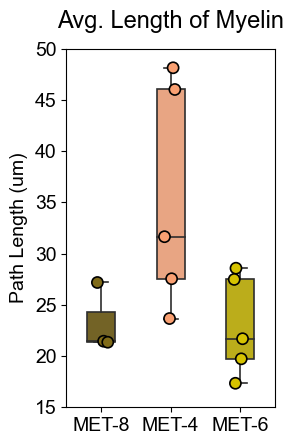

In [88]:
# ###Avg myelin length 
####number of myelin segment
seg_len_mean = mye_id_avg.groupby('met_type').mean()
seg_len_sem = mye_id_avg.groupby('met_type').sem()
seg_len_mean["sem"] = seg_len_sem["euc_dist_um"]
seg_len_mean = seg_len_mean.reindex(["MET8", "MET4", "MET6"])
print (seg_len_mean)
####plot average length of myelin
plt.figure()
plt.rcParams["figure.figsize"] = (2.95,4.55)

ax3 =sns.boxplot(x = "met_type", y = "euc_dist_um", palette = met_color, data = mye_id_avg, linewidth = 1.2, width = 0.4, order = ordermet)
sns.stripplot(x = "met_type", y = "euc_dist_um", palette = met_color, edgecolor = "black", jitter = True, linewidth = 1.2, s = 8, data = mye_id_avg, marker = 'o', ax = ax3, order = ordermet)

afont = {'fontname':'Arial'}
plt.xticks (rotation = 360, fontsize = 14, **afont)
plt.yticks (fontsize = 14, **afont)
ax3.set_xlabel('', fontsize = 14, **afont)
# ax2.get_legend().remove()
ax3.xaxis.labelpad = 10
ax3.yaxis.labelpad = 5
plt.ylim(15, 50)
t = ax.yaxis.get_offset_text()
t.set_size(14)
ax3.set_xticklabels(["MET-8", "MET-4", "MET-6"])

plt.title('Avg. Length of Myelin', fontsize = 17, **afont, pad = 15)
ax3.set_ylabel('Path Length (um)', fontsize = 14, **afont)

plt.tight_layout()
# plt.savefig('Avg_met_reord_mye_segment_um_17_metcolor_bbatch_1114.pdf', bbox_inches = 'tight', transparent = 'True')
